# Scene Understanding using Deep Learning
## Introduction

This Notebook was written for demonstrating scene understanding for the Lockheed Martin drone challange. The code consists of three pipelines pre-processing, FCN and post processing  The project is a corner stone for  

\<img style="float: center;" src="readme_imgs/Img_groundtruth.png">

## Data Pre-processing 

We have implemented camera calibration routine to the video file.Each image was normalized and then smoothed with a Gaussian filter. The images were randomly processed with a brightness filter to help the network generalize to different lighting conditions. 

 


## FCN

 

 
 

##  Jaccard similarity coefficient 

In evaluating the model I've investigated several metrics including the Mean IU, Intersection over Union, and the Jaccard coefficient. The idea is to maximize the overlap between the predicted region and the ground truth bounding box.
 
We eventually decided to use the Jaccard coeef. The Jaccard similarity coefficient is defined as the size of the intersection divided by the size of the union of two regions. This metric is used to compare the predicted labels to a set of labels in y_true  

The coefficients are given by 

#### J(A,B) = |A∩B| / |A∪B|=|A∩B|/|A|+|B|-|A∩B| 

(If A and B are both empty, we define J(A,B) = 1.)

<img style="float: center;" src="readme_imgs/Intersection_of_sets_A_and_B.png">
<img style="float: center;" src="readme_imgs/Intersection_of_sets_A_and_B_2.png">
 

## Training

The Autti dataset was used and can be obtained from https://github.com/udacity/self-driving-car/tree/master/annotations .  

## Results
 

In [1]:
%matplotlib inline
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import glob
import time
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import pandas as pd
import keras.backend as K
from sklearn.metrics import jaccard_similarity_score
from keras.layers import Input, Dense, BatchNormalization, merge, Activation
import time
import numpy
from PIL import Image, ImageDraw
import re
from shapely.geometry import Polygon
from pprint import pprint
import PIL.ImageDraw
from PIL import Image
import argparse
import os
 
#add a note for the class

Using TensorFlow backend.


# Reading and processing the wkt json format 


In [2]:
#df is the dataset that we are annotating
#raw_df is the dataset that the organizers provided
#adding path for json anf image folders respectively
provided_data_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/csv/training_GT_labels.json'#json provided by the organizers of the challange
our_data_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/csv/data_wkt_v2.json'#our annotated dataset
img_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/Data_Training/'#folder where images are stored
provided_df = pd.read_json(provided_data_file_dir)
df = pd.read_json(our_data_file_dir)

 
#adding a complete path for the image 
df['External ID']= [img_file_dir + u for u in df['External ID']]#iris_data_dir + new_df['parcel_id'].astype(str) + '.jpg'

df['images']=[u.split('/',8)[8] for u in df['External ID']]
raw_df=pd.DataFrame()
raw_df['images']=list(provided_df.columns.values)
raw_df['img_path']=[img_file_dir +  u for u in raw_df['images']]

raw_df['raw_inner_poly']=[ provided_df[u][0] for u in raw_df['images']]

raw_df.head()


,images,img_path,raw_inner_poly
0,IMG_8378.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[616, 278, 948, 290, 945, 616, 609, 627]"
1,IMG_3034.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[502, 255, 663, 373, 673, 696, 492, 677]"
2,IMG_2082.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[504, 165, 829, 224, 819, 580, 489, 590]"
3,IMG_7209 (1).JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[409, 285, 774, 292, 781, 642, 387, 646]"
4,IMG_5207.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[494, 311, 765, 267, 768, 663, 495, 644]"


In [3]:
#remove white spaces from image path
s=raw_df['images'][3]
print(re.sub(r"\s+", "", s))  # \s matches all white spaces

IMG_7209(1).JPG


#remove white space from image name in the folder containing the images

#go to img directory and run python fix.py. Here is the file

#remove white space from image name in the folder containing the images
import os
import re

""" 
Renames the filenames within the same directory to be Unix friendly
(1) Changes spaces to nothing
(2) Makes lowercase (not a Unix requirement, just looks better ;)
Usage:
python rename.py
"""
path =  os.getcwd()
 
filenames = os.listdir(path)

for filename in filenames:
    print('img name befor',filename)
    fixed_filename=re.sub(r"\s+", "", filename)
    print('img name after',fixed_filename)
    os.rename(filename, fixed_filename)

In [4]:
df.head()

,Agreement,Created At,Created By,DataRow ID,Dataset Name,External ID,ID,Label,Labeled Data,Project Name,Reviews,Seconds to Label,View Label,images
0,NaN,2019-02-06T08:35:37.000Z,alberto.galet@gmail.com,cjrsurb5r9p7w0anvd23j1pgg,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxucjqqkbd0b47j8vcjsua,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.832,https://image-segmentation-v4.labelbox.com?pro...,IMG_0015.JPG
1,NaN,2019-02-06T08:36:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p800anv2xkrhfkw,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxvb54qkw90b47dwa8uupg,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],44.299,https://image-segmentation-v4.labelbox.com?pro...,IMG_0158.JPG
2,NaN,2019-02-06T08:36:55.000Z,alberto.galet@gmail.com,cjrsurb5v9p840anv7ly4rt5s,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxw0feqs9n08984nfshogi,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],31.955,https://image-segmentation-v4.labelbox.com?pro...,IMG_0244.JPG
3,NaN,2019-02-07T02:17:15.000Z,alberto.galet@gmail.com,cjrsurb5v9p880anvyjs4m1oj,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzrm18i8ga08983qewu7rq,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.032,https://image-segmentation-v4.labelbox.com?pro...,IMG_0367.JPG
4,NaN,2019-02-07T02:18:01.000Z,alberto.galet@gmail.com,cjrsurb5v9p8c0anvcve1d63y,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzslxpi69j0b4753lkl3ju,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],46.003,https://image-segmentation-v4.labelbox.com?pro...,IMG_0374.JPG


In [5]:
#merge the our annotations and provided annotations
df_all=pd.merge(df, raw_df, on='images')
df_all.head(10)

,Agreement,Created At,Created By,DataRow ID,Dataset Name,External ID,ID,Label,Labeled Data,Project Name,Reviews,Seconds to Label,View Label,images,img_path,raw_inner_poly
0,NaN,2019-02-06T08:35:37.000Z,alberto.galet@gmail.com,cjrsurb5r9p7w0anvd23j1pgg,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxucjqqkbd0b47j8vcjsua,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.832,https://image-segmentation-v4.labelbox.com?pro...,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[504, 191, 902, 177, 915, 580, 495, 584]"
1,NaN,2019-02-06T08:36:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p800anv2xkrhfkw,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxvb54qkw90b47dwa8uupg,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],44.299,https://image-segmentation-v4.labelbox.com?pro...,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[454, 212, 803, 221, 808, 552, 454, 566]"
2,NaN,2019-02-06T08:36:55.000Z,alberto.galet@gmail.com,cjrsurb5v9p840anv7ly4rt5s,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxw0feqs9n08984nfshogi,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],31.955,https://image-segmentation-v4.labelbox.com?pro...,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[590, 376, 791, 371, 794, 589, 577, 601]"
3,NaN,2019-02-07T02:17:15.000Z,alberto.galet@gmail.com,cjrsurb5v9p880anvyjs4m1oj,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzrm18i8ga08983qewu7rq,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.032,https://image-segmentation-v4.labelbox.com?pro...,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[836, 385, 641, 387, 635, 582, 841, 582]"
4,NaN,2019-02-07T02:18:01.000Z,alberto.galet@gmail.com,cjrsurb5v9p8c0anvcve1d63y,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzslxpi69j0b4753lkl3ju,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],46.003,https://image-segmentation-v4.labelbox.com?pro...,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[470, 221, 848, 231, 851, 613, 457, 609]"
5,NaN,2019-02-07T02:18:42.000Z,alberto.galet@gmail.com,cjrsurb5v9p8g0anv2ji1v57l,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzth7bi7210b47l0yydz0t,{'Outer Border': [{'geometry': 'POLYGON ((567 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.919,https://image-segmentation-v4.labelbox.com?pro...,IMG_0396.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[585, 338, 684, 354, 672, 523, 592, 532]"
6,NaN,2019-02-07T02:19:13.000Z,alberto.galet@gmail.com,cjrsurb5v9p8k0anv1auzm8e0,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzu5bziasw0898zn0xuaez,{'Outer Border': [{'geometry': 'POLYGON ((343 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],30.653,https://image-segmentation-v4.labelbox.com?pro...,IMG_0861.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[378, 468, 533, 480, 537, 646, 369, 646]"
7,NaN,2019-02-07T02:19:47.000Z,alberto.galet@gmail.com,cjrsurb5v9p8o0anv56veqecf,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzuvrni8r10b47jq56iqvh,{'Outer Border': [{'geometry': 'POLYGON ((753 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.630,https://image-segmentation-v4.labelbox.com?pro...,IMG_1128.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[509, 319, 705, 255, 705, 632, 506, 616]"
8,NaN,2019-02-07T02:20:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p8s0anvm6kjs3ge,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/..

In [6]:

keep_cols=['images', 'img_path','Label','raw_inner_poly']
df_all=df_all[keep_cols]
df_all['outer_poly']=''
df_all['inner_poly']=''
df_all['outer_x_min']=''
df_all['outer_y_min']=''
df_all['outer_x_max']=''
df_all['outer_y_max']=''
df_all['inner_x_min']=''
df_all['inner_y_min']=''
df_all['inner_x_max']=''
df_all['inner_y_max']=''
df_all['class_id']= ''
print(len(df_all))
df_all.head()

2534


,images,img_path,Label,raw_inner_poly,outer_poly,inner_poly,outer_x_min,outer_y_min,outer_x_max,outer_y_max,inner_x_min,inner_y_min,inner_x_max,inner_y_max,class_id
0,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,"[504, 191, 902, 177, 915, 580, 495, 584]",,,,,,,,,,,
1,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,"[454, 212, 803, 221, 808, 552, 454, 566]",,,,,,,,,,,
2,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,"[590, 376, 791, 371, 794, 589, 577, 601]",,,,,,,,,,,
3,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,"[836, 385, 641, 387, 635, 582, 841, 582]",,,,,,,,,,,
4,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,"[470, 221, 848, 231, 851, 613, 457, 609]",,,,,,,,,,,


raw_inner_poly [511, 247, 850, 271, 853, 609, 506, 616]
poly [511, 247, 850, 271, 853, 609, 506, 616]
raw_inner_poly [492, 400, 665, 390, 667, 596, 489, 590]
poly [492, 400, 665, 390, 667, 596, 489, 590]


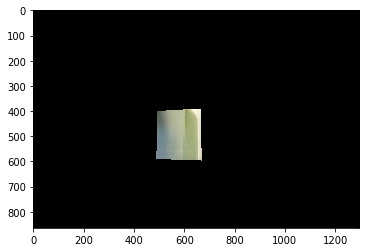

In [7]:
# checking the mask from the provided GT by the organizers



#processing the polygone and creating a mask
def get_mask_raw_data(img_shape, poly,display=False):
    output_mask = np.zeros(img_shape[:2], dtype=np.uint8)
    print('poly',poly)

    coords =  zip(*[iter(poly)] * 2) 
     
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    x = []
    y = []
    polygons = []

    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    proc_polygons=np.vstack((x,y)).T
    x,y,w,h = cv2.boundingRect(proc_polygons) 
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
for i in range(444,446):#len(df)):

    img=cv2.imread(df_all['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    #outer_poly=df['Label'][i] 
    inner_poly=df_all['raw_inner_poly'][i]
    if inner_poly:
        print('raw_inner_poly',inner_poly)
    #outer_mask=get_mask(img_shape,outer_poly,display=False)
        inner_mask=get_mask_raw_data(img_shape,inner_poly,display=False)
        inner_mask.dtype='uint8'
    #outer_mask.dtype='uint8'
    #final_mask=cv2.subtract(outer_mask,inner_mask)
        plt.imshow(cv2.bitwise_and(img,img,mask=inner_mask))
        plt.show
    else:
        print('polygon data corruption detected for index:', i)

test_id=1
test_poly=df['Label'][test_id]['Outer Border']#df['outer_poly'][1] 


In [8]:
#convert the polygons into a format that can be convereted to bounding boxes 
from tqdm import tqdm
#preprocessing our_dataset

def convert_coordinates(poly):
    proc_poly=poly[0]['geometry']
    nums =  re.findall(r'\d+(?:\.\d*)?', proc_poly.rpartition(',')[0])
    coords =  zip(*[iter(nums)] * 2)
    polygons = []
    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    return polygons 
def convert_coordinates_raw(polygon):
    poly=[]
    polygon =  zip(*[iter(polygon)] * 2)
    for p in polygon:
        poly.append(p)
    return poly
def get_bbox(polygon):
    polygon=polygon[0]['geometry']
    polygon=(polygon)

    polygon =  re.findall(r'\d+(?:\.\d*)?', polygon)
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack((x,y)).T
   
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
def get_bbox_raw_data(polygon):
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
 
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack(((x,y))).T
    
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
for i in tqdm(range(0,len(df_all))):
    #remove white spaces from image path
   
    df_all['img_path'][i]=re.sub(r"\s+", "", df_all['img_path'][i]) # \s matches all white spaces
    outer_poly=df_all['Label'][i]['Outer Border']
    inner_poly=df_all['raw_inner_poly'][i]#df['Label'][i]['inner flyable area']
    if inner_poly and outer_poly:
        df_all['outer_poly'][i] = convert_coordinates(outer_poly)
        df_all['inner_poly'][i] = convert_coordinates_raw(inner_poly)
        #df['inner_poly'][i] = convert_coordinates(inner_poly)

        df_all['outer_x_min'][i],df_all['outer_y_min'][i], df_all['outer_x_max'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
        df_all['inner_x_min'][i],df_all['inner_y_min'][i], df_all['inner_x_max'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly)
        #df_all['outer_x_min'][i],df_all['outer_x_max'][i], df_all['outer_y_min'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
        #df_all['inner_x_min'][i],df_all['inner_x_max'][i], df_all['inner_y_min'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly) 
    else:
        print('corrupt data detected for index:', i )
        continue
    #df['outer_poly']= h
   #df['inner_poly']= convert_coordinates(inner_poly)

100%|██████████| 2534/2534 [00:01<00:00, 1512.40it/s]


In [9]:
df_all.head()

,images,img_path,Label,raw_inner_poly,outer_poly,inner_poly,outer_x_min,outer_y_min,outer_x_max,outer_y_max,inner_x_min,inner_y_min,inner_x_max,inner_y_max,class_id
0,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,"[504, 191, 902, 177, 915, 580, 495, 584]","[(997, 65), (1014, 683), (402, 673), (416, 106)]","[(504, 191), (902, 177), (915, 580), (495, 584)]",402,65,1015,684,495,177,916,585,
1,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,"[454, 212, 803, 221, 808, 552, 454, 566]","[(894, 638), (375, 646), (383, 136), (882, 141)]","[(454, 212), (803, 221), (808, 552), (454, 566)]",375,136,895,647,454,212,809,567,
2,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,"[590, 376, 791, 371, 794, 589, 577, 601]","[(848, 312), (851, 649), (533, 639), (538, 328)]","[(590, 376), (791, 371), (794, 589), (577, 601)]",533,312,852,650,577,371,795,602,
3,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,"[836, 385, 641, 387, 635, 582, 841, 582]","[(597, 623), (880, 627), (881, 344), (603, 346)]","[(836, 385), (641, 387), (635, 582), (841, 582)]",597,344,882,628,635,385,842,583,
4,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,"[470, 221, 848, 231, 851, 613, 457, 609]","[(359, 703), (950, 711), (943, 141), (384, 128)]","[(470, 221), (848, 231), (851, 613), (457, 609)]",359,128,951,712,457,221,852,614,


outer poly [(997, 65), (1014, 683), (402, 673), (416, 106)]
inner_poly [(504, 191), (902, 177), (915, 580), (495, 584)]


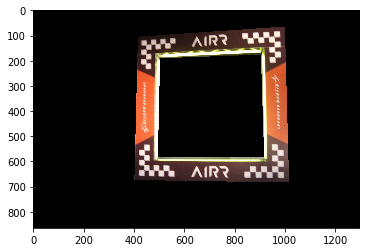

In [10]:
# testing annotation all together 

def get_mask(img_shape, poly,display=False):
     

    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    polygons = []
    for pt in poly:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
#getting the final mask

for i in range(0,1):#len(df)): # use one image only for testing

    img=cv2.imread(df_all['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    outer_poly=df_all['outer_poly'][i] 
    print('outer poly',outer_poly)
    inner_poly=df_all['inner_poly'][i]
    print('inner_poly', list(inner_poly))
    outer_mask=get_mask(img_shape,outer_poly,display=False)
    inner_mask=get_mask(img_shape,inner_poly,display=False)
    inner_mask.dtype='uint8'
    outer_mask.dtype='uint8'
    final_mask=cv2.subtract(outer_mask,inner_mask)
    plt.imshow(cv2.bitwise_and(img,img,mask=final_mask))
    plt.show

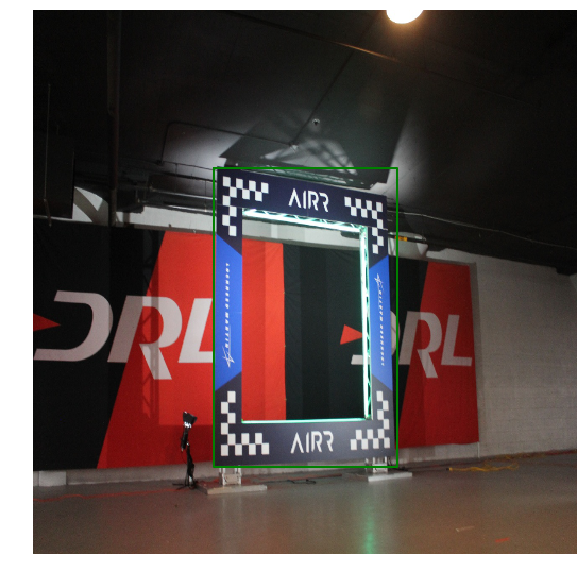

In [11]:
#test the bounding box coordinates
def im_read(df,ID,resize = True, size=(640,300),augumentation=True, display=True):
    #Return the index at which the image is first found in a list - Python
    file_name = df['img_path'][ID]
    #img = read_img(file_name)
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    #print(img_size )
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if resize == True:
        img = cv2.resize(img,size)
    if augumentation == True:
        img = brightness_images(img)
    #str.split(str="", num=string.count(str)).
    img_name = df['images'][ID]
    bb_boxes = df[df['images'] == img_name].reset_index()
    img_size_post = np.shape(img)
     
    bb_boxes['outer_x_min'] = np.round(int(bb_boxes['outer_x_min']/img_size[1]*img_size_post[1]))
    bb_boxes['outer_x_max'] = np.round(int(bb_boxes['outer_x_max']/img_size[1]*img_size_post[1]))
    bb_boxes['outer_y_min'] = np.round(int(bb_boxes['outer_y_min']/img_size[0]*img_size_post[0]))
    bb_boxes['outer_y_max'] = np.round(int(bb_boxes['outer_y_max']/img_size[0]*img_size_post[0]))
    bb_boxes['Area'] = (int(bb_boxes['outer_x_max']- bb_boxes['outer_x_min'])*(bb_boxes['outer_y_max']- bb_boxes['outer_y_min'])) 
    if display == True:
        plt.figure(figsize=(16,10))
        plt.subplot(1,1,1)
        plot_im_bbox(img,bb_boxes)
    return img_name,img,bb_boxes

def get_mask_seg(img,bb_boxes_f):
    img_mask = np.zeros_like(img[:,:,0])
    for i in range(len(bb_boxes_f)):
        bb_box_i = [bb_boxes_f.iloc[i]['outer_x_min'],bb_boxes_f.iloc[i]['outer_y_min'],
                bb_boxes_f.iloc[i]['outer_x_max'],bb_boxes_f.iloc[i]['outer_y_max']]
        img_mask[bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2]]= 1.
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask

def plot_bbox(bb_boxes,ind_bb,color='r',linewidth=2):
    bb_box_i = [bb_boxes.iloc[ind_bb]['outer_x_min'],
                bb_boxes.iloc[ind_bb]['outer_y_min'],
                bb_boxes.iloc[ind_bb]['outer_x_max'],
                bb_boxes.iloc[ind_bb]['outer_y_max']]
    plt.plot([bb_box_i[0],bb_box_i[2],bb_box_i[2],
                  bb_box_i[0],bb_box_i[0]],
             [bb_box_i[1],bb_box_i[1],bb_box_i[3],
                  bb_box_i[3],bb_box_i[1]],
             color,linewidth=linewidth)
def plot_im_bbox(im,bb_boxes):
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes,i,'g')

        bb_box_i = [bb_boxes.iloc[i]['outer_x_min'],bb_boxes.iloc[i]['outer_y_min'],
                bb_boxes.iloc[i]['outer_x_max'],bb_boxes.iloc[i]['outer_y_max']]
    plt.axis('off'); 

test_img_name,img,bb_boxes = im_read(df_all,2000,resize = True, size=(512,512), augumentation=False, display = True)


In [12]:
#add a class ID 


## Extended preprocessing pipeline for Yolo V3
Data need to be of the following format and exported to a txt file
image_path x_min y_min x_max y_max class_id  x_min y_min ... class_id
```
xxx/xxx.jpg 18.19 6.32 424.13 421.83 20 323.86 2.65 640.0 421.94 20 
xxx/xxx.jpg 55.38 132.63 519.84 380.4 16
``` 

In [13]:
#convert a small df_all sample
 


In [14]:
#keep only filed required by yolov3. Divide the dataframe into outer and inner bounding boxes and then assign a class to each one of them 
keep_cols_outer=['img_path', 'outer_x_min', 'outer_y_min', 'outer_x_max', 'outer_y_max', 'class_id']
keep_cols_inner=['img_path', 'inner_x_min', 'inner_y_min', 'inner_x_max', 'inner_y_max', 'class_id']
df_outer=df_all[keep_cols_outer]
df_inner=df_all[keep_cols_inner]
df_outer['class_id']=0
df_inner['class_id']=1
df_yolo=pd.merge(df_outer, df_inner, on='img_path')
df_yolo.head()

,img_path,outer_x_min,outer_y_min,outer_x_max,outer_y_max,class_id_x,inner_x_min,inner_y_min,inner_x_max,inner_y_max,class_id_y
0,/media/a/D/lockheed-martin/dataset/LM_dataset/...,402,65,1015,684,0,495,177,916,585,1
1,/media/a/D/lockheed-martin/dataset/LM_dataset/...,375,136,895,647,0,454,212,809,567,1
2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,533,312,852,650,0,577,371,795,602,1
3,/media/a/D/lockheed-martin/dataset/LM_dataset/...,597,344,882,628,0,635,385,842,583,1
4,/media/a/D/lockheed-martin/dataset/LM_dataset/...,359,128,951,712,0,457,221,852,614,1


In [15]:
# write data to txt as required by yolo v3
df_yolo.to_csv('/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_data.csv', sep=' ',encoding='utf-8', index=False,header=False)

In [16]:
# write data to txt as required by yolo v3
#np.savetxt(r'gates_data.txt', df_yolo.values, fmt='%d')

# Deeplearning pipeline

###### Code for this part was adopted from https://github.com/YunYang1994/tensorflow-yolov3

#I created 3 files for the training


```
/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates.names

/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates.anchors

/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_data.csv```



In [17]:
# need to generate the tf records for the training and testing dataset using the 
# following commands in shell

# python /media/a/D/lockheed-martin/AlphaPilot_test2/object_segmentation_pipelines/tensorflow-yolov3/core/convert_tfrecord.py --dataset_txt /media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_data.csv --tfrecord_path_prefix gates_train
# python /media/a/D/lockheed-martin/AlphaPilot_test2/object_segmentation_pipelines/tensorflow-yolov3/core/convert_tfrecord.py --dataset_txt /media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_data.csv --tfrecord_path_prefix gates_test
# which yeilds
#/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_train.tfrecords
#/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_test.tfrecords

In [18]:
#display and check a random image  
from core import utils
import tensorflow as tf
from core.dataset import Parser, dataset
sess = tf.Session()

IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE = 1
SHUFFLE_SIZE = 1

train_tfrecord = "/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_*.tfrecords"
anchors        = utils.get_anchors('/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_anchors.txt', IMAGE_H, IMAGE_W)
classes = utils.read_coco_names('/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates.names')
num_classes = len(classes)

parser   = Parser(IMAGE_H, IMAGE_W, anchors, num_classes, debug=True)
trainset = dataset(parser, train_tfrecord, BATCH_SIZE, shuffle=SHUFFLE_SIZE)

is_training = tf.placeholder(tf.bool)
example = trainset.get_next()

for l in range(0,1):
    image, boxes = sess.run(example)
    image, boxes = image[0], boxes[0]

    n_box = len(boxes)
    for i in range(n_box):
        image = cv2.rectangle(image,(int(float(boxes[i][0])),
                                     int(float(boxes[i][1]))),
                                    (int(float(boxes[i][2])),
                                     int(float(boxes[i][3]))), (255,0,0), 1)
        label = classes[boxes[i][4]]
        image = cv2.putText(image, label, (int(float(boxes[i][0])),int(float(boxes[i][1]))),
                            cv2.FONT_HERSHEY_SIMPLEX,  .6, (0, 255, 0), 1, 2)

    image = Image.fromarray(np.uint8(image))
    image.show()

In [19]:
# download and convert yolo weights from https://github.com/YunYang1994/tensorflow-yolov3/releases/download/v1.0/yolov3.weights
#  python convert_weight.py --convert

In [1]:
#! /usr/bin/env python
# coding=utf-8
#================================================================
#   Copyright (C) 2019 * Ltd. All rights reserved.
#
#   Editor      : VIM
#   File name   : quick_train.py
#   Author      : YunYang1994
#   Created date: 2019-01-21 14:46:26
#   Description :
#
#================================================================

import tensorflow as tf
from core import utils, yolov3
from core.dataset import dataset, Parser
sess = tf.Session()

IMAGE_H, IMAGE_W = 128,128#416, 416
BATCH_SIZE       = 1
EPOCHS           = 2
LR               = 0.001 # if Nan, set 0.0005, 0.0001
DECAY_STEPS      = 100
DECAY_RATE       = 0.9
SHUFFLE_SIZE     = 200
CLASSES          = utils.read_coco_names('/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates.names')
ANCHORS          = utils.get_anchors('/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_anchors.txt', IMAGE_H, IMAGE_W)
NUM_CLASSES      = len(CLASSES)
EVAL_INTERNAL    = 100
SAVE_INTERNAL    = 500
train_tfrecord   = "/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_train.tfrecords"
test_tfrecord    = "/media/a/D/lockheed-martin/dataset/LM_dataset/csv/gates_test.tfrecords"

parser   = Parser(IMAGE_H, IMAGE_W, ANCHORS, NUM_CLASSES)
trainset = dataset(parser, train_tfrecord, BATCH_SIZE, shuffle=SHUFFLE_SIZE)
testset  = dataset(parser, test_tfrecord , BATCH_SIZE, shuffle=None)

is_training = tf.placeholder(tf.bool)
example = tf.cond(is_training, lambda: trainset.get_next(), lambda: testset.get_next())

images, *y_true = example
model = yolov3.yolov3(NUM_CLASSES, ANCHORS)
print('model loaded')
 
with tf.variable_scope('yolov3'):
    pred_feature_map = model.forward(images, is_training=is_training)
    loss             = model.compute_loss(pred_feature_map, y_true)
    y_pred           = model.predict(pred_feature_map)

tf.summary.scalar("loss/coord_loss",   loss[1])
tf.summary.scalar("loss/sizes_loss",   loss[2])
tf.summary.scalar("loss/confs_loss",   loss[3])
tf.summary.scalar("loss/class_loss",   loss[4])

global_step = tf.Variable(0, trainable=False, collections=[tf.GraphKeys.LOCAL_VARIABLES])
write_op = tf.summary.merge_all()
writer_train = tf.summary.FileWriter("./data/train")
writer_test  = tf.summary.FileWriter("./data/test")

saver_to_restore = tf.train.Saver(var_list=tf.contrib.framework.get_variables_to_restore(include=["yolov3/darknet-53"]))
update_vars = tf.contrib.framework.get_variables_to_restore(include=["yolov3/yolo-v3"])
learning_rate = tf.train.exponential_decay(LR, global_step, decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)

# set dependencies for BN ops
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss[0], var_list=update_vars, global_step=global_step)
sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
saver_to_restore.restore(sess, "/media/a/D/lockheed-martin/checkpoint/yolov3.ckpt")
saver = tf.train.Saver(max_to_keep=2)


model loaded
INFO:tensorflow:Restoring parameters from ./checkpoint/yolov3.ckpt


In [ ]:


for epoch in range(EPOCHS):
    run_items = sess.run([train_op, write_op, y_pred, y_true] + loss, feed_dict={is_training:True})

    if (epoch+1) % EVAL_INTERNAL == 0:
        train_rec_value, train_prec_value = utils.evaluate(run_items[2], run_items[3])

    writer_train.add_summary(run_items[1], global_step=epoch)
    writer_train.flush() # Flushes the event file to disk
    if (epoch+1) % SAVE_INTERNAL == 0: saver.save(sess, save_path="/media/a/D/lockheed-martin/checkpoint/yolov3.ckpt", global_step=epoch+1)

    print("=> EPOCH %10d [TRAIN]:\tloss_xy:%7.4f \tloss_wh:%7.4f \tloss_conf:%7.4f \tloss_class:%7.4f"
        %(epoch+1, run_items[5], run_items[6], run_items[7], run_items[8]))

    run_items = sess.run([write_op, y_pred, y_true] + loss, feed_dict={is_training:False})
    if (epoch+1) % EVAL_INTERNAL == 0:
        test_rec_value, test_prec_value = utils.evaluate(run_items[1], run_items[2])
        print("\n=======================> evaluation result <================================\n")
        print("=> EPOCH %10d [TRAIN]:\trecall:%7.4f \tprecision:%7.4f" %(epoch+1, train_rec_value, train_prec_value))
        print("=> EPOCH %10d [VALID]:\trecall:%7.4f \tprecision:%7.4f" %(epoch+1, test_rec_value,  test_prec_value))
        print("\n=======================> evaluation result <================================\n")

    writer_test.add_summary(run_items[0], global_step=epoch)
    writer_test.flush() # Flushes the event file to disk


In [ ]:
#Method to read image. CV2 reads images in BGR and the simulator provides images in RGB. Therefore convert to 
#RGB domain
def read_img(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

#Image brigtness changing method, based on Vivek Yadav's [2] approach for changing image brightness
def brightness_images(img):
    post_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    post_img[:,:,2] = np.multiply(post_img[:,:,2],random_bright)
    post_img = cv2.cvtColor(post_img,cv2.COLOR_HSV2RGB)
    return post_img
# Another approach to adjust brightness used for experimentation 
def brightness_images_2(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  
    h, s, v = cv2.split(hsv)
    v += 255
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img
# Resize the image to the givin dimensions 
def resize_img(image, col, row):
    image = cv2.resize(image, (col,row), interpolation=cv2.INTER_AREA)
    return image
# Crop away the car hood from the orginal image  
def crop_img(img):
    shape = img.shape
    img = img[0:shape[0]-20,0:shape[1]]
    img = resize_img(img, 64, 64)
    return img

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def transform(img):
    imshape = img.shape
    img_size = (img.shape[1], img.shape[0])
    #src=np.float32([[160,imshape[0]],[imshape[1]/2-60, imshape[0]/2+90],[imshape[1]/2+100, imshape[0]/2+90], [imshape[1]-20,imshape[0]]])
    #dst=np.float32([[(240,imshape[0]),(240, 0),(imshape[1]-130, 0), (imshape[1]-130,imshape[0])]])
    src = np.float32([[490, 482],[810, 482],
                     [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    wraped =  cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)
    
    return  Minv, wraped


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#Implement calibration on the images that will be used
def undistort(img, read=True, display=True, write=False):

# Test undistortion on an image
    
    if read:
        img = cv2.imread(img)
    img_size = (img.shape[1], img.shape[0])
#img = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
#dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    if write:
        cv2.imwrite('Undistorted/test6.jpg',dst)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        img_RGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax1.imshow(img_RGB)
        ax1.set_title('Original Image', fontsize=30)
        dst_RGB=cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        ax2.imshow(dst_RGB)
        ax2.set_title('Undistorted Image', fontsize=30)
    else:
        return dst


In [ ]:
## Method to get the image and resize it if required
def im_read(df,ID,resize = True, size=(640,300),augumentation=True, display=True):
    #Return the index at which the image is first found in a list - Python
    
    file_name = df['File_Path'][ID]
    #img = read_img(file_name)
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    #print(img_size )
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if resize == True:
        img = cv2.resize(img,size)
    if augumentation == True:
        img = brightness_images(img)
    #str.split(str="", num=string.count(str)).
    img_name = df['Frame'][ID]#file_name.split('/',1)[1]
    
    bb_boxes = df[df['Frame'] == img_name].reset_index()
    
    img_size_post = np.shape(img)  
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1])
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1])
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0])
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0])
    bb_boxes['Area'] = (bb_boxes['xmax']- bb_boxes['xmin'])*(bb_boxes['ymax']- bb_boxes['ymin'])
   
    if display == True:
        plt.figure(figsize=(16,10))
        plt.subplot(1,1,1)
        plot_im_bbox(img,bb_boxes)
    return img_name,img,bb_boxes

def get_mask_seg(img,bb_boxes):
    print(bb_boxes)
    img_mask = np.zeros_like(img[:,:,0])
    for i in range(len(bb_boxes)):
        bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
        print(bb_box_i)
        img_mask[int(bb_box_i[1]):int(bb_box_i[3]),int(bb_box_i[0]):int(bb_box_i[2])]= 1
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask

def plot_bbox(bb_boxes,ind_bb,color='r',linewidth=2):
    bb_box_i = [bb_boxes.iloc[ind_bb]['xmin'],
                bb_boxes.iloc[ind_bb]['ymin'],
                bb_boxes.iloc[ind_bb]['xmax'],
                bb_boxes.iloc[ind_bb]['ymax']]
    plt.plot([bb_box_i[0],bb_box_i[2],bb_box_i[2],
                  bb_box_i[0],bb_box_i[0]],
             [bb_box_i[1],bb_box_i[1],bb_box_i[3],
                  bb_box_i[3],bb_box_i[1]],
             color,linewidth=linewidth)
def plot_im_bbox(im,bb_boxes):
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes,i,'g')

        bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
    plt.axis('off'); 
 

In [ ]:
cars_35GB.head()

In [ ]:
#testing the mail function
df=cars_35GB
ID=660
test_img_name,img,bb_boxes = im_read(cars_35GB,ID,resize = True, size=(640,300), augumentation=False, display = True)

In [ ]:
# Test an image with it's bounding boxes
#print (cars_15_35GB)
df=cars_35GB
ID=660
test_img_name,img,bb_boxes = im_read(cars_35GB,ID,resize = True, size=(640,300), augumentation=False, display = False)
img_masked = get_mask_seg(img,bb_boxes)
print('img.shape',img.shape)
plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
plot_im_bbox(img,bb_boxes)
plt.title('Raw image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_masked[:,:,0])
plt.title('Raw image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.bitwise_and(img,img,mask=img_masked))
plt.title('Raw image')
plt.axis('off')

In [ ]:
def generate_train_batch(data,batch_size):
    #col=size[0]
    #row=size[1]
    batch_images = np.zeros((batch_size, row, col, 3))
    #batch_steering = np.zeros(batch_size)
    batch_masks = np.zeros((batch_size, row, col, 1))
    training_batch = len(data)-100000
    while 1:
        for i_batch in range(batch_size):
            
            process_line = np.random.randint(training_batch)
            #generator_csv= data.iloc[[process_line]].reset_index()
            #x,y = all_filters_train(generator_csv)
            #print(data)
            img_name,img,bb_boxes = im_read(data,process_line,resize = True, size=(col,row), augumentation=True, display = False)
            img_masked = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] = img_masked
        yield batch_images, batch_masks

def generate_test_batch(data,batch_size):
    batch_images = np.zeros((batch_size, row, col, 3))
    #batch_steering = np.zeros(batch_size)
    batch_masks = np.zeros((batch_size, row, col, 1))
    training_batch = len(data)-100000
    while 1:
        for i_batch in range(batch_size):
            process_line = np.random.randint(training_batch)
            process_line = process_line+training_batch
            #generator_csv= data.iloc[[process_line]].reset_index()
            #x,y = all_filters_train(generator_csv)
            img_name,img,bb_boxes = im_read(data,process_line,resize = True, size=(col,row), augumentation=True, display = False)
            img_masked = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] = img_masked
        yield batch_images, batch_masks
"""        
def generate_validation_patch(data):
    while 1:
        for process_line in range(len(data)):
            generator_csv = data.iloc[[process_line]].reset_index()
            x = all_filters_validate(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = generator_csv['steering'][0]
            y = np.array([[y]])
            yield x, y
def save_model(fileModelJSON,fileWeights):
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    
"""

In [ ]:
row = 640
col = 960

In [ ]:
# for custom metrics
#custom metrix source : https://keras.io/metrics/
#Use this as a template
#def mean_pred(y_true, y_pred):
    #return K.mean(y_pred)

#def false_rates(y_true, y_pred):
    #false_neg = ...
    #false_pos = ...
    #return {
        #'false_neg': false_neg,
        #'false_pos': false_pos,
    #}

#model.compile(optimizer='rmsprop',
              #loss='binary_crossentropy',
             # metrics=['accuracy', mean_pred, false_rates])

def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

#to do: fbeta_score(y_true, y_pred, beta=1) 



# Training pipeline

In [ ]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [ ]:
# Train the model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras_yolov3_kitti.yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from keras_yolov3_kitti.yolo3.utils import get_random_data
log_dir='logs'
anchors_path = 'keras_yolov3_kitti/model_data/yolo_anchors.txt'
classes_path = 'keras_yolov3_kitti/model_data/voc_classes.txt'
num_classes=2#len(class_names)
anchors = get_anchors(anchors_path)
input_shape =(300,640)
is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='keras_yolov3_kitti/model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='keras_yolov3_kitti/model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})
batch_size = 32
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=25,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
model.save_weights(log_dir + 'trained_weights_stage_1.h5')

for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 4 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=25,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')


# Post-processing pipeline      

In [ ]:
smooth = 1.
heatmap_prev = np.zeros((640,960))
heatmap_10 = [np.zeros((640,960))]*10
def smooth_heatmap(heatmap):
    #Credit Vive Yadav
    # Smoothing heatmap as average of 10 previous frames
    global heatmap_10
    heatmap_10_1 = heatmap_10[1:]
    heatmap_10_1.append(heatmap)
    heatmap_10 = heatmap_10_1
    heatmap = np.mean(heatmap_10,axis=0)
    
    #heatmap = heatmap_prev*.2 + heatmap*.8
    #heatmap[heatmap>240] = 255
    #heatmap[heatmap<240] = 0
    return heatmap 
 

def next_img(img, resize=True):
    if resize == True:
        img = cv2.resize(img,(col,row))
        img = np.reshape(img,(1,row, col,3))
    pred = model.predict(img)
    return pred,img[0]

def draw_labeled_bboxes(img, labels):
    """Return image with bounding boxes drawn around the labelled regions.
    """
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        # increasing or reducing the sensetivity of bounding box noise
        if ((np.max(nonzeroy)-np.min(nonzeroy)>70) & (np.max(nonzerox)-np.min(nonzerox)>70)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))      
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    # Return the image
    return img

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = next_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = im_pred[:,:,0]
    #Create an image with some features, then label it using the default (cross-shaped) structuring element:
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

def get_labeled_bboxes(img, labels):
    # Get labeled boxex
    bbox_all = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)> 40) & (np.max(nonzerox)-np.min(nonzerox)> 40)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image       
            #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
            bbox_all.append(bbox)
    # Return the image
    return bbox_all

#credits Vivek Yadav
def get_BB_new(img):
    # Take in RGB image
    pred,img = next_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = img_pred[:,:,0]
    heatmap = smooth_heatmap(heatmap)
    #print(np.max(heatmap))
    heatmap[heatmap> 240] = 255
    heatmap[heatmap<=240] = 0    
    labels = label(heatmap)
    
    bbox_all = get_labeled_bboxes(np.copy(img), labels)
    return bbox_all

def get_Unet_mask(img):
    
    # Take in RGB image
    pred,img = next_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = img_pred[:,:,0]
    heatmap = smooth_heatmap(heatmap)
    labels = label(heatmap)
    return heatmap


In [ ]:
start = time.time()
training_gen = generate_train_batch(cars_15_35GB,1)
batch_img,batch_mask = next(training_gen)
end = time.time()
end-start

In [ ]:
start = time.time()
sample_imgs=1 
testing_gen = generate_test_batch(cars_15_35GB,sample_imgs)
pre_final_predictions= model.predict(batch_img)
end = time.time()
end-start

In [ ]:
### Test on last frames of data
start = time.time()
batch_img,batch_mask = next(testing_gen)
pre_final_predictions= model.predict(batch_img)
np.shape(pre_final_predictions)
for i in range(sample_imgs):
    im=batch_img[i]
    pred,im = next_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    img_true = cv2.addWeighted(rgb_mask_true,0.70,im,0.70,0)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.70,im,1,0)
    draw_img = get_BB_new_img(im)
    plt.figure(figsize=(14,5))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(img_pred)
    plt.title('Segmented')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(draw_img)
    plt.title('Predicted')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(img_true)
    plt.title('Gtruth')
    plt.axis('off')

end = time.time()
end-start   

In [ ]:
test_img = 'scene01021.jpg'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = next_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]

img_pred = cv2.addWeighted(rgb_mask_pred,0.70,im,1,0)

draw_img = get_BB_new_img(im)

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentated')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off');



## Performing camera calibration
Camera calibration is performed in order to correct the deformation in the images that is caused to the optic lens curvature. The first step is to print a chessboard and take random pictures of it. Then count the chess intersecting squires to provide "objp" which holds the (x,y,z) coordinates of these corners. Z=0 here and the object points are the same for all images in the calibration folder. The objpoints will be appended in "objp" every time the method successfully detect all chessboard corners in a test image. "imgpoints" will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.
"objpoints" and "imgpoints" were used to compute the camera calibration and distortion coefficients using the "cv2.calibrateCamera()" function on a test image in "cv2.undistort()"

In [ ]:
# prepare object points. The number of corners are 6x9
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images, all located in camera_cal
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # imread reads images in BGR format
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

## Perform distortion removal on test images¶
1. Has the distortion correction been correctly applied to each image?
Undistortion is performed on the provided test images before they are used in the pipeline. This also applies to the video frames. "dst" holds undistorted frames from "cv2.undistort" that were computed using "mtx".

In [ ]:
for image_name in glob.glob("Frames/*"):
    im = cv2.imread(image_name)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = undistort(im,read=False, display = False, write = False)
    pred,im = next_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.50,im,1,0)
    draw_img = get_BB_new_img(im)
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Segmentated')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(draw_img)
    plt.title('Bounding Box')
    plt.axis('off');

heatmap_10 = [np.zeros((640,960))]*10
    

In [ ]:
def video_pipeline(image):
    #test_img = 'scene01021.jpg'
    #im = cv2.imread(im)
    #im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    #img = get_BB_new_img(im)
    # Apply bounding box to image
    image_bb = np.copy(image)
    bbox_cars = get_BB_new(image_bb)
    img_size = np.shape(image)
    result = image
    img_res_shape = result.shape
    for bbox in bbox_cars:
        cv2.rectangle(result,(np.int32(bbox[0][0]*img_res_shape[1]/960),np.int32(bbox[0][1]*img_res_shape[0]/640)), (np.int32(bbox[1][0]*img_res_shape[1]/960),np.int32(bbox[1][1]*img_res_shape[0]/640)),(0,255,0),6)
    #heatmap = get_Unet_mask(image_bb)
    #plt.imshow(img)
    return result

In [ ]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) 
white_clip.write_videofile(video_output, audio=False)

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))